## Introduction
In this notebook data collected from hugging face is preprocessed for classification task.<br />
classifier is trained to predict whether an X-Ray of a patient shows signs of pneumonia or not based on the RSNA Pneumonia Detection Challenge (https://huggingface.co/datasets/Baldezo313/rsna-pneumonia-dataset).

## Data Collection

The dataset used for this experiment is RSNA pneumonia detection challenge dataset. The dataset available at HuggingFace repository and accessible at 

- https://huggingface.co/datasets/Baldezo313/rsna-pneumonia-dataset/tree/main

Or from Google Drive link : 

To download dataset from huggingFace platform, in command prompt run the following git command to download the data
1. Install git lfs
> git lfs install

2.  clone the dataset repo
> git clone https://huggingface.co/datasets/Baldezo313/rsna-pneumonia-dataset

After executing above command, a new directoy (rsna-pneumonia-dataset) will be created. This directory contains following directories and file.

- stage_2_test_images
- stage_2_train_images_0
- stage_2_train_images_1
- stage_2_train_images_2
- stage_2_detailed_class_info.csv
- stage_2_sample_submission.csv
- stage_2_train_labels.csv

Create a new directory called "train_images" inside the root directory.
Move all the .dcm files from stage_2_train_images_0, stage_2_train_images_1, stage_2_train_images_2 directories to "train_images".

- move .dcm file from stage_2_train_images_0 to train_images
- move .dcm file from stage_2_train_images_1 to train_images
- move .dcm file from stage_2_train_images_2 to train_images

After performing above steps final rsna-pneumonia-dataset directory should contains following directories and files.

- train_images
- stage_2_test_images
- stage_2_detailed_class_info.csv
- stage_2_sample_submission.csv
- stage_2_train_labels.csv

Following directories and files can be safely removed or ignored. As these files are not applicable to the current project.

- stage_2_test_images- 
stage_2_detailed_class_info.cs
- 
stage_2_sample_submission.csv

Define the root path to the rsna-pneumonia-dataset directory.

In [4]:
root_path_to_dataset = "root/path/to/rsna-pneumonia-dataset"

<b>Or get the preprocessed zip file from the following link.</b>
> https://drive.google.com/file/d/1pjMCimi8fs1W0ccrwF4nkP0vKUYG_szR/view?usp=sharing

Note: If processed zip file is used, then data preprocessing is not required. Skip the data preprocessing step and move directly WRN-50-2 and WRN-101-2 model training.

## Data Preprocessing

## Imports
* pathlib for convenient path handling
* pydicom for reading dicom files
* numpy for storing the actual images
* cv2 for directly resizing the images
* pandas to read the provided labels
* matplotlib for visualizing some images
* tqdm for nice progress bar

In [1]:
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
print(pydicom.__version__)

2.4.4


Define the path to the DICOM files and also the path where the processed NPY files will be stored.

In [8]:
path_to_train_labels = root_path_to_dataset + "/stage_2_train_labels.csv"
path_to_train_images = root_path_to_dataset + "/train_images/"
path_to_save_processed_files =  root_path_to_dataset + "/processed/"

Read the csv file containing the labels

In [4]:
labels = pd.read_csv(path_to_train_labels)

In [5]:
labels.head(6)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


Note that subjects may occur multiple times in the dataset because different pneumonia spots are handled individually. For the classification task, these duplicates can be removed as only the binary label is of interest.

In [6]:
labels.patientId.size

30227

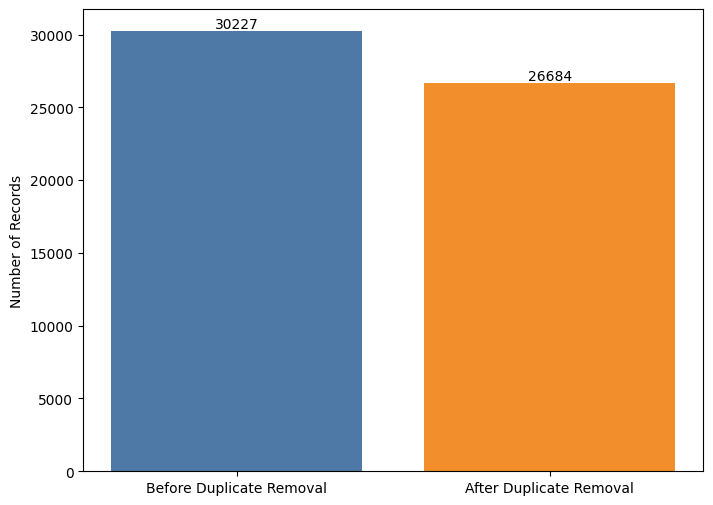

In [7]:
import matplotlib.pyplot as plt

# Sample data for image labels
captions = ['Before Duplicate Removal', 'After Duplicate Removal']
image_counts = [30227, 26684]  # Assuming 1500 images for label 0 and 500 images for label 1
# Create a bar graph
plt.figure(figsize=(8, 6))
bars = plt.bar(captions, image_counts, color=['#4E79A7', '#F28E2B'])
plt.ylabel('Number of Records')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height}', ha='center', va='bottom')

plt.show()

In [8]:
# Remove duplicate entries
labels = labels.drop_duplicates("patientId")

In [9]:
labels.head(10)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
10,008c19e8-a820-403a-930a-bc74a4053664,NaN,NaN,NaN,NaN,0
11,009482dc-3db5-48d4-8580-5c89c4f01334,NaN,NaN,NaN,NaN,0


In [10]:
labels.patientId.size

26684

Define the path to the DICOM files and also the path where the processed NPY files will be stored.

In [11]:
ROOT_PATH = Path(path_to_train_images)
SAVE_PATH = Path(path_to_save_processed_files)

008c19e8-a820-403a-930a-bc74a4053664 0


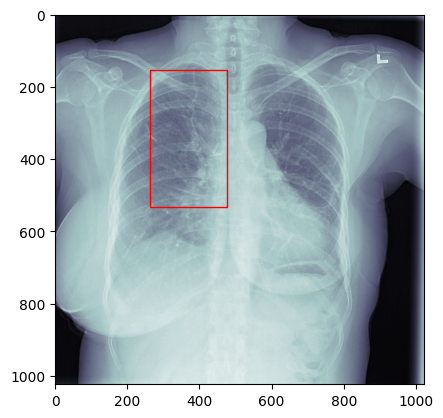

In [51]:
c = 8
patient_id = labels.patientId.iloc[c]

dcm_path = ROOT_PATH/patient_id
dcm_path = dcm_path.with_suffix(".dcm")
dcm = pydicom.read_file(dcm_path).pixel_array

dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float16)

label = labels["Target"].iloc[c]
print(patient_id, label)
plt.imshow(dcm, cmap="bone")
train_or_val = "sample"
current_save_path = SAVE_PATH/train_or_val # Define save path and create if necessary
current_save_path.mkdir(parents=True, exist_ok=True)
np.save(current_save_path/patient_id, dcm_array)

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Display the image
# plt.imshow(Image.open('stinkbug.png'))

# Add the patch to the Axes
plt.gca().add_patch(Rectangle((264.0,152.0),213.0,379.0,linewidth=1,edgecolor='r',facecolor='none'))

Inspect some example images

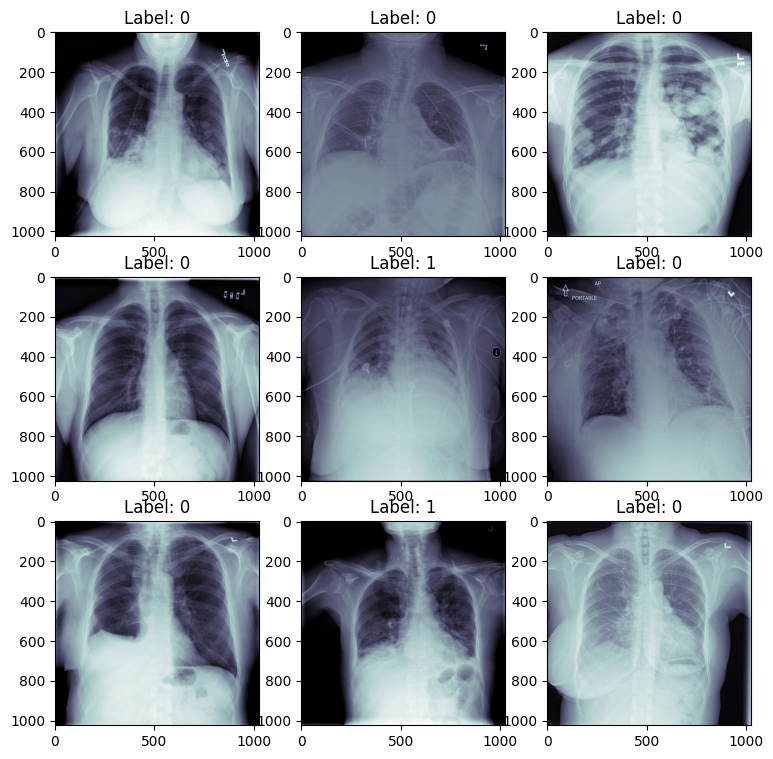

In [52]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))
c = 0
for i in range(3):
    for j in range(3):
        patient_id = labels.patientId.iloc[c]
        dcm_path = ROOT_PATH/patient_id
        dcm_path = dcm_path.with_suffix(".dcm")
        dcm = pydicom.read_file(dcm_path).pixel_array
        
        label = labels["Target"].iloc[c]
        
        axis[i][j].imshow(dcm, cmap="bone")
        axis[i][j].set_title(f"Label: {label}")
        c+=1

## Dicom Reading & Effective storage

To efficiently handle the data in the DataLoader, the X-Ray images stored in the DICOM format are converted to numpy arrays. Afterwards, the overall mean and standard deviation of the pixels of the whole dataset are computed for normalization purposes. The created numpy images are then stored in two separate folders according to their binary label:

- 0: All X-Rays which do not show signs of pneumonia
- 1: All X-Rays which show signs of pneumonianiaf pneumonia

To do so, iterate over the patient IDs and concatenate the patient ID with the ROOT_PATH.

Directly save the standardized and resized files into the corresponding directory (0 for healthy, 1 for pneumonia). This allows taking advantage of the ready-to-use torchvision DatasetFolder for simple file reading.

Standardize all images by the maximum pixel value in the provided dataset, which is 255. All images are resized to 224x224.

To compute the dataset mean and standard deviation, calculate the sum of the pixel values as well as the sum of the squared pixel values for each subject. This allows computing the overall mean and standard deviation without keeping the whole dataset in memory.

In [53]:
sums = 0
sums_squared = 0
tr = 0
ts = 0
va = 0
for c, patient_id in enumerate(tqdm(labels.patientId)):
    dcm_path = ROOT_PATH/patient_id  # Create the path to the dcm file
    dcm_path = dcm_path.with_suffix(".dcm")  # And add the .dcm suffix
    
    # Read the dicom file with pydicom and standardize the array
    dcm = pydicom.read_file(dcm_path).pixel_array / 255  
        
    # Resize the image as 1024x1024 is way to large to be handeled by Deep Learning models at the moment
    # Let's use a shape of 224x224
    # In order to use less space when storing the image we convert it to float16
    dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float16)
    
    # Retrieve the corresponding label
    label = labels.Target.iloc[c]

   
    # 4/5 train split, 1/5 val split
    if c < 19200:
        train_or_val = "train"
        tr += 1
    elif c < 24000:
        train_or_val = "test"
        ts += 1
    else:
        train_or_val = "val" 
        va += 1


    current_save_path = SAVE_PATH/train_or_val/str(label) # Define save path and create if necessary
    current_save_path.mkdir(parents=True, exist_ok=True)
    np.save(current_save_path/patient_id, dcm_array)  # Save the array in the corresponding directory
    
    normalizer = dcm_array.shape[0] * dcm_array.shape[1]  # Normalize sum of image
    if train_or_val == "train":  # Only use train data to compute dataset statistics
        sums += np.sum(dcm_array) / normalizer
        sums_squared += (np.power(dcm_array, 2).sum()) / normalizer
print(f"train: {tr}, Test: {ts}, Val: {va}")

  0%|          | 0/26684 [00:00<?, ?it/s]

train: 19200, Test: 4800, Val: 2684


In [56]:
mean = sums / 19200
std = np.sqrt(sums_squared / 19200 - (mean**2))

The mean and standard deviation will be used later in the DataLoader to normalize the data.

In [57]:
print(f"Mean of Dataset: {mean}, STD: {std}")

Mean of Dataset: 0.49066507560055184, STD: 0.24807117954497443


After executing the notebook, "processed" directory will be created under the root directory. This directory should be containing three directory "train", "val" and "test" each containing the pneumonia files with .npy extension.